In [21]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd 
from scipy.fft import fft
import scipy.signal as signal
import seaborn as sns
import re
from math import log10

**SE OBTIENE EL DATASET**




In [22]:
new_data=pd.read_csv('DataECG_PostEjercicio.csv',skiprows=[1], quotechar="'", index_col=0)
print(new_data)

              0
1     -0.075425
2     -0.081877
3     -0.088328
4     -0.081877
5     -0.072199
...         ...
53995 -0.049619
53996 -0.036716
53997 -0.033490
53998 -0.043167
53999 -0.052845

[53999 rows x 1 columns]


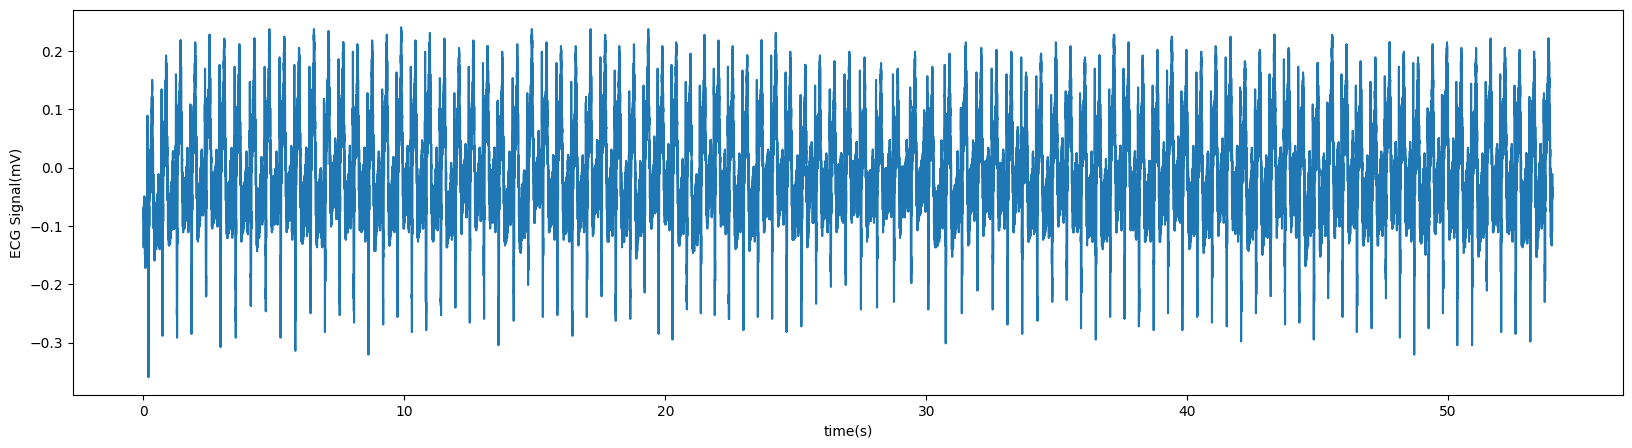

In [23]:
voltaje = new_data.to_numpy()
voltaje = voltaje - np.mean(voltaje)
t = np.arange(len(voltaje))/1000; #Sampling frequency: 1000 Hz
plt.figure(figsize=(20,5));plt.plot(t,voltaje);plt.ylabel('ECG Signal(mV)');plt.xlabel('time(s)')
plt.show()

**SE ANALIZA LA SEÑAL EN FRECUENCIA**

Conociendo los datos de adquisición de la señal, analicemos ahora el espectro de Fourier.

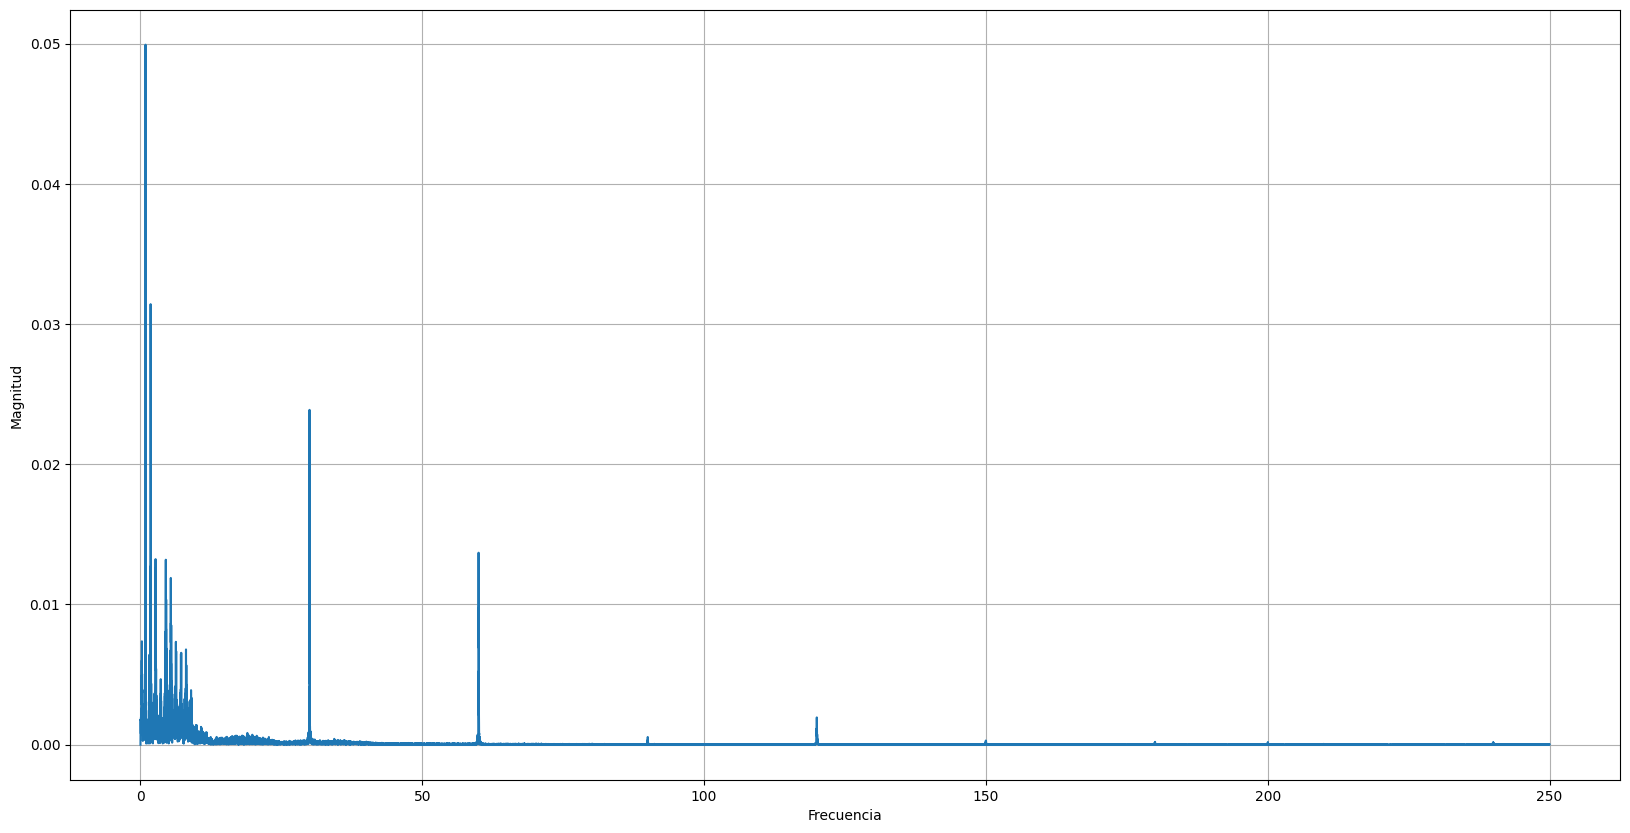

In [24]:
# Analizar el Fourier
ecg_senal = voltaje[:,0]
# Periodo de 2ms (0.002s) o frecuencia de 500 Hz
T = 0.002
N = len(ecg_senal)
yf = fft(ecg_senal)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.figure(figsize=(20,10))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]));
plt.grid();plt.xlabel("Frecuencia");plt.ylabel("Magnitud")
plt.show()

En el gráfico anterior, existe un ruido en los armonicos 30 Hz, 60 Hz, 90 Hz y 120 Hz. Por lo tanto, se debe filtrar.

Se propone utilizar filtros digitales Notch



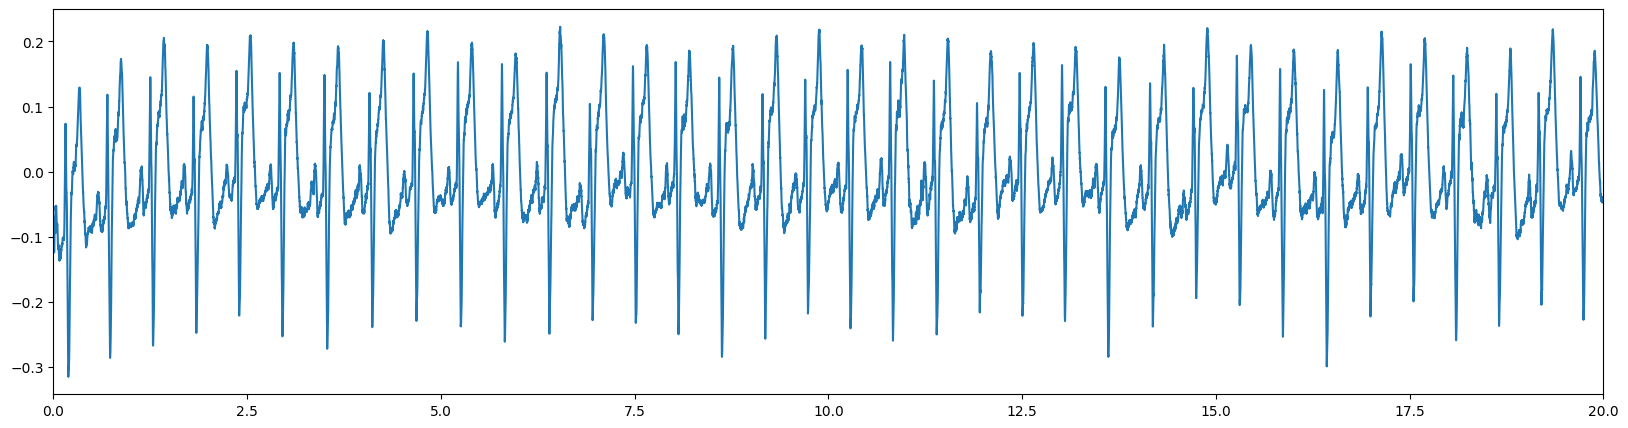

In [25]:
# Utilizar filtros Notch para quitar frecuencias que hagan ruido
from scipy.signal import iirnotch, lfilter

fs = 1/T  # Frecuencia de muestreo (Hz)
f0 = 30.0  # Frecuencia que queremos filtrar (Hz)
Q = 20.0  # Factor de Calidad
# Diseño de filtro notch
b, a = iirnotch(f0, Q, fs)
y = lfilter(b, a, ecg_senal)
y = lfilter(b, a, y)

f0 = 60.0  # Frecuencia que queremos filtrar (Hz)
Q = 7.0  # Factor de Calidad
# Diseño de filtro notch
b, a = iirnotch(f0, Q, fs)
y = lfilter(b,a,y)

f0 = 90.0  # Frecuencia que queremos filtrar (Hz)
# Diseño de filtro notch
b, a = iirnotch(f0, Q, fs)
y = lfilter(b,a,y)

f0 = 120.0  # Frecuencia que queremos filtrar (Hz)
# Diseño de filtro notch
b, a = iirnotch(f0, Q, fs)
y = lfilter(b,a,y)

plt.figure(figsize=(20,5)),plt.xlim(0,20);#Ploteamos los 20 primeros segundos de la señal
plt.plot(t,y)
plt.show()

Regresamos a verificar las atenuaciones de los filtros en frecuencia

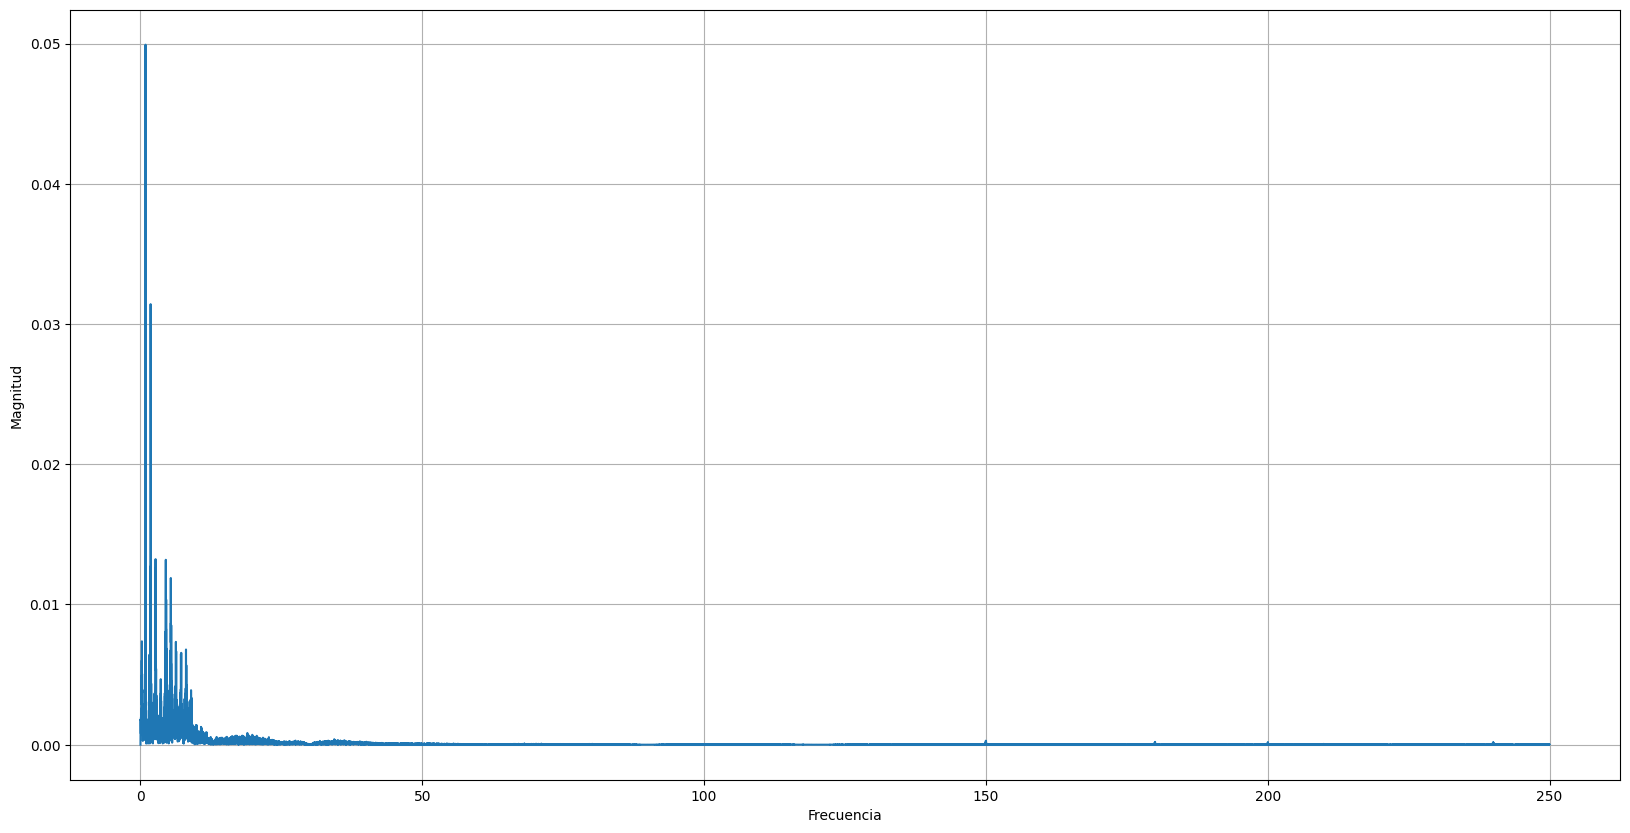

In [26]:
# Analisis de Fourier de los filtros
# Periodo de 2ms (0.002s) o frecuencia de 500 Hz
T = 0.002
N = len(y)
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.figure(figsize=(20,10))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]));plt.grid();plt.xlabel("Frecuencia");plt.ylabel("Magnitud");plt.show()
ecg_signal = y

**FILTRADO DE PASA BANDA**

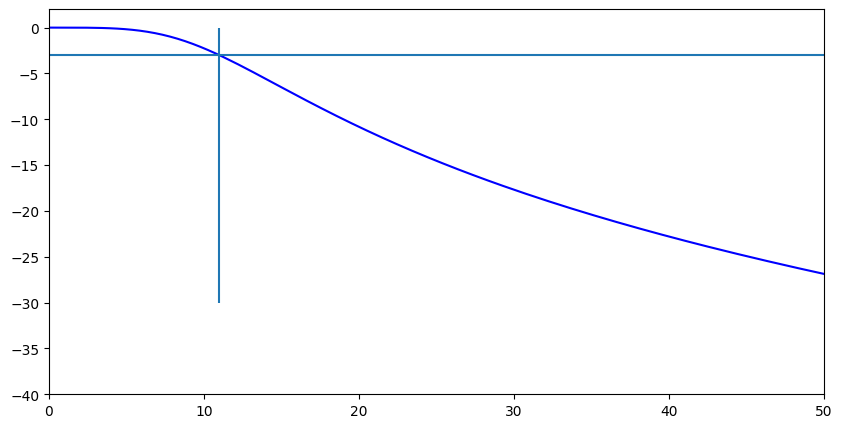

In [27]:
from scipy.signal import freqz, iirdesign, iirfilter, find_peaks
# 2. filtro pasa banda
# Sub filtro pasa bajo
b, a = iirfilter(2, 11.0, btype='lowpass', rs=3, ftype='butter', fs=500)
w, h = freqz(b, a, fs=500)
plt.figure(figsize=(10,5))
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.hlines(-3,0,250)
plt.xlim(0,50)
plt.vlines(11, -30, 0)
plt.ylim(-40,2)
plt.show()

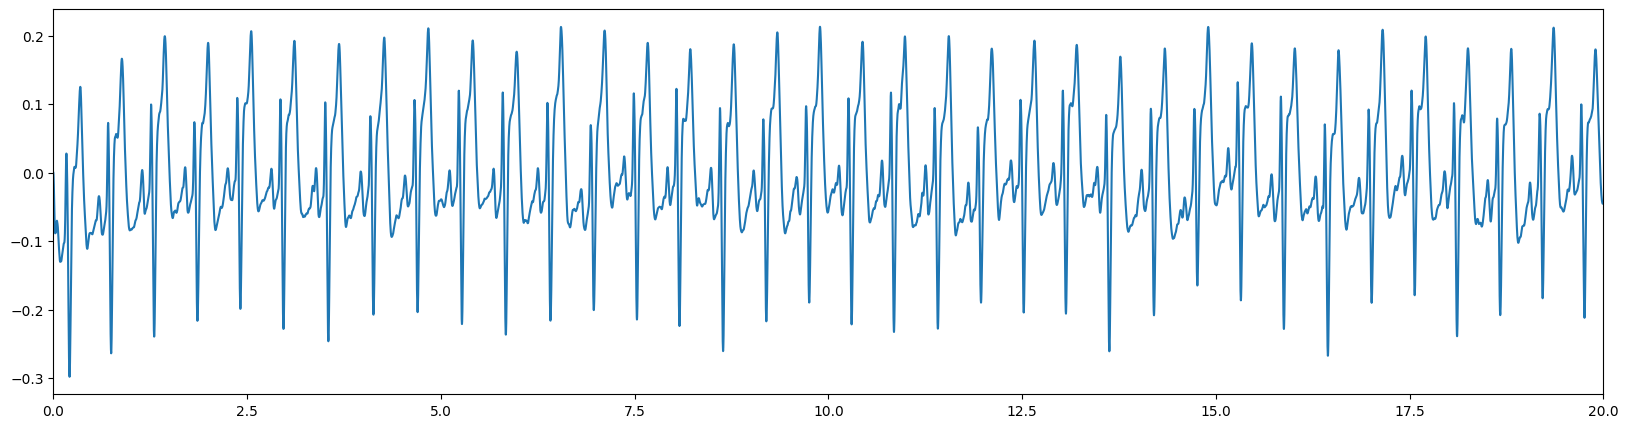

In [28]:
fpb_signal = lfilter(b, a, ecg_signal)
plt.figure(figsize=(20,5))
plt.plot(t,fpb_signal);plt.xlim(0,20)
plt.show()

**FILTRO PASA ALTO**

C:\Users\Alessandra\AppData\Local\Temp\ipykernel_5792\1745212953.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(abs(h)), 'b')


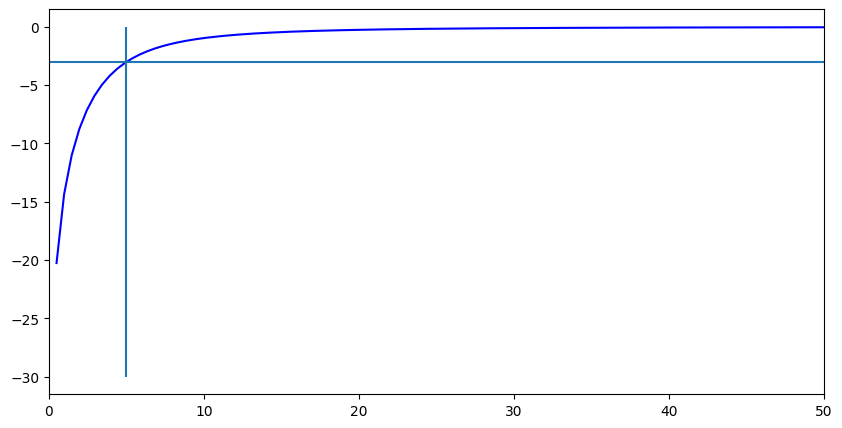

In [29]:
b, a = iirfilter(1, 5.0, btype='highpass', rs=3, ftype='butter', fs=500)
w, h = freqz(b, a, fs=500)
plt.figure(figsize=(10,5))
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.hlines(-3,0,250);plt.xlim(0,50)
plt.vlines(5, -30, 0)
plt.show()


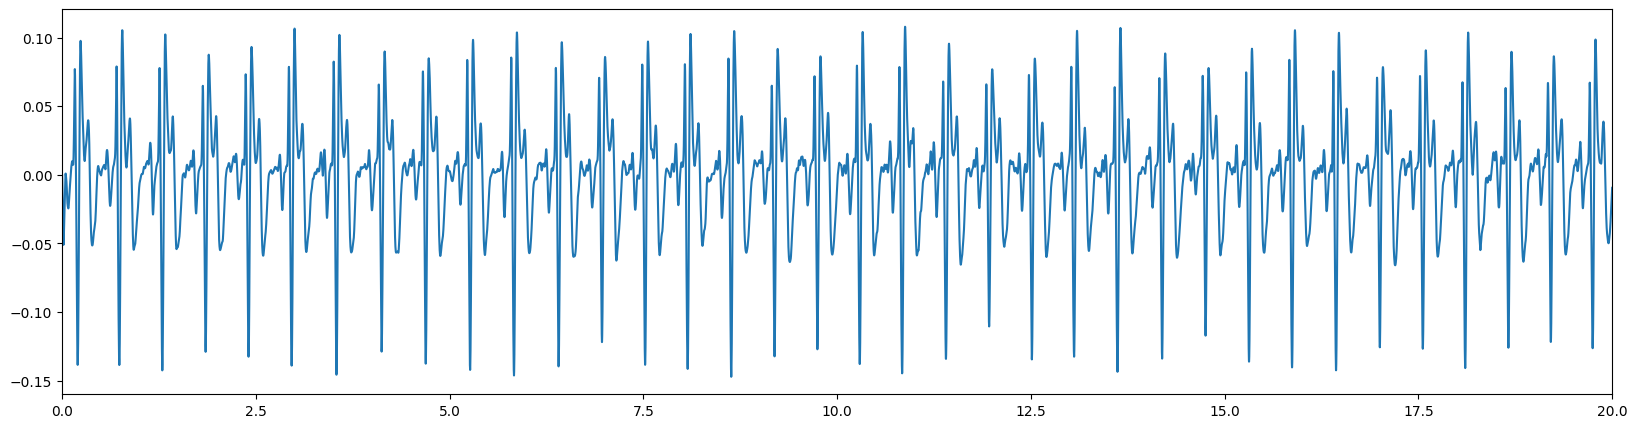

In [30]:
fpa_signal = lfilter(b, a, fpb_signal)
plt.figure(figsize=(20,5))
plt.plot(t,fpa_signal);plt.xlim(0,20)
plt.show()

**OPERADOR DERIVATIVO**

En el artículo nos dan la siguiente función que describe al operador:

y[n]=(1/8)(−x[n−2]−2x[n−1]+2x[n+1]+x[n+2])

Para que esta ecuación pueda ser utilizada necesitamos encuadrarla en un rango de  [0,+∞]  haciendo que  n=+2  entonces tenemos:

y[n]=(1/8)(−x[n]−2x[n+1]+2x[n+3]+x[n+4]) 

Por lo tanto:

b=[−1,−2,0,2,1]

C:\Users\Alessandra\AppData\Local\Temp\ipykernel_5792\73101146.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(abs(h)), 'b')


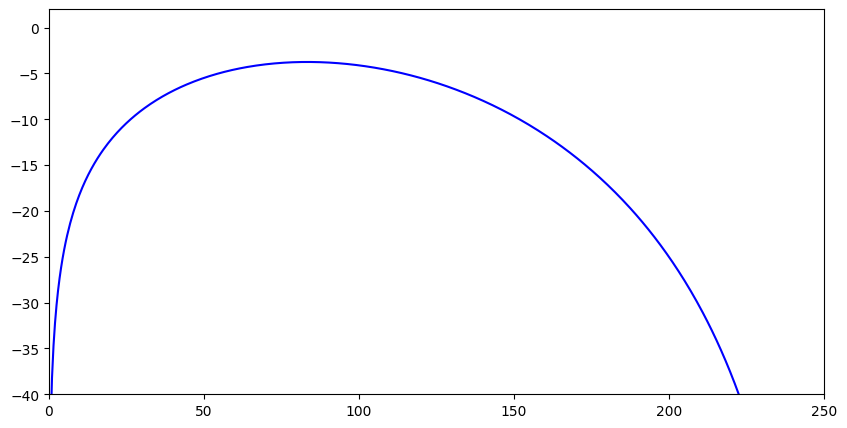

In [31]:
# Filtro derivativo
b = np.array([-1, -2, 0, 2, 1])
b = (1/8)*b
w, h = freqz(b, 1, fs=500)
plt.figure(figsize=(10,5))
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.xlim(0,250)
plt.ylim(-40,2)
plt.show()

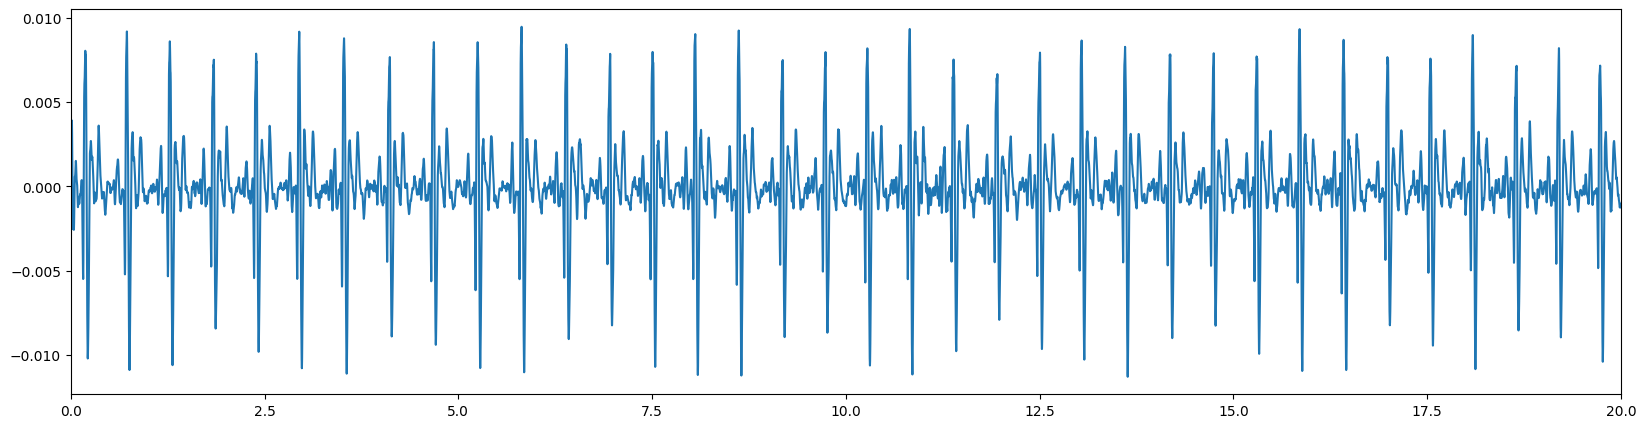

In [32]:
fd_signal = lfilter(b, 1, fpa_signal)
plt.figure(figsize=(20,5))
plt.plot(t,fd_signal);plt.xlim(0,20)
plt.show()

**OPERADOR CUADRÁTICO**

Este operador solo tiene como función elevar al cuadrado los valores de la señal.

y[n]=x^2[n]

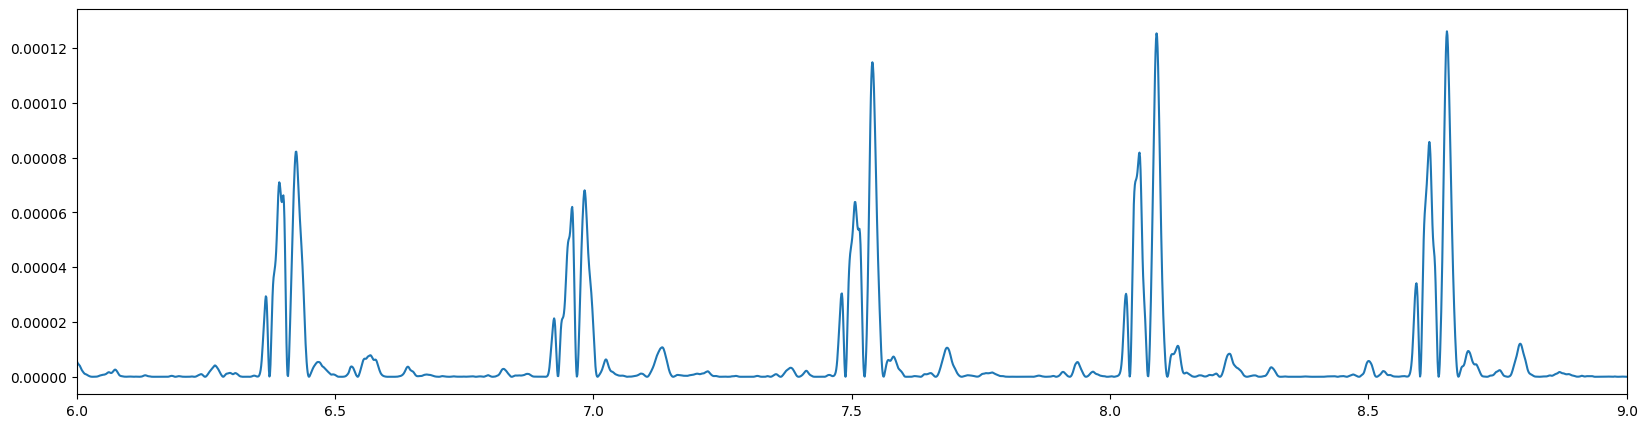

In [33]:
# Filtro cuadrado
f_sq = np.square(fd_signal)
plt.figure(figsize=(20,5))
plt.plot(t, f_sq);plt.xlim(6,9)
plt.show()

**OPERADOR MOVING WINDOW INTEGRATION**

Este operador tiene como función extraer ciertas características de la onda.

y[n]=(1/N)(x[n−(N−1)]+x[n−(N−2)]+..+x[n])

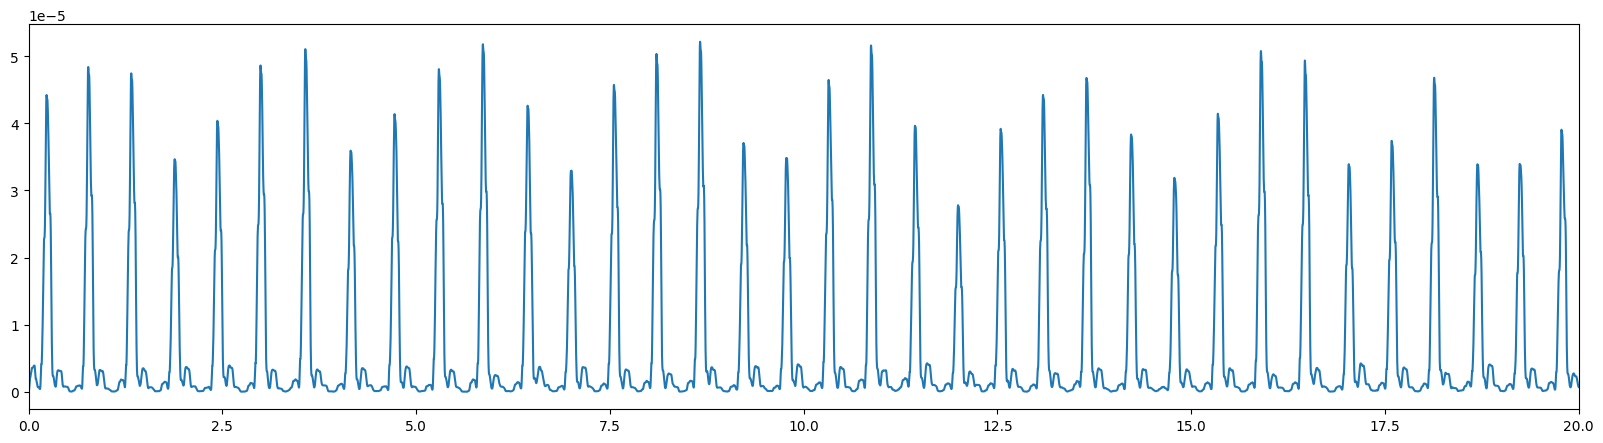

In [34]:
# Moving-Window Integration
N = 75
b = np.ones(N-1)
b = (1/N)*b
fi_signal = lfilter(b, 1, f_sq)
plt.figure(figsize=(20,5))
plt.plot(t,fi_signal);plt.xlim(0,20)
plt.show()

Colocando marcadores en los picos

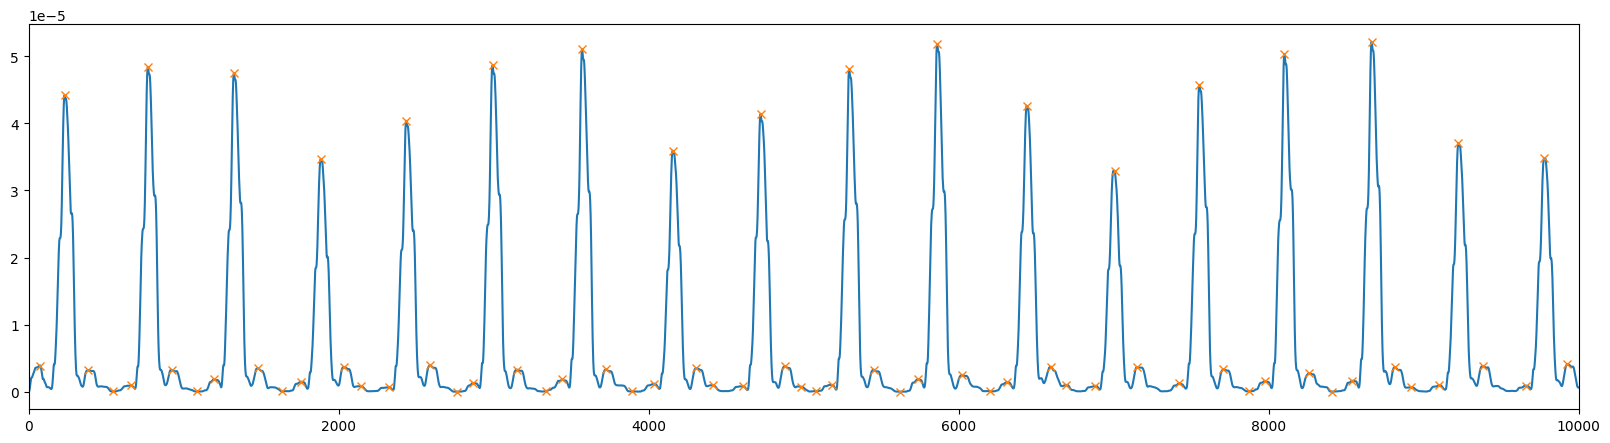

In [35]:
# Fiducial Marks
peaks, _ = find_peaks(fi_signal, distance=100)
plt.figure(figsize=(20,5))
plt.plot(fi_signal); plt.xlim([0,10000])
plt.plot(peaks, fi_signal[peaks], "x")
plt.show()

**ANÁLISIS DE THRESHOLD**

El valor del umbral de pico R de entrada es  1.3038923966592042e-05
El valor del umbral de ruido de entrada es  5.7881012554993265e-06


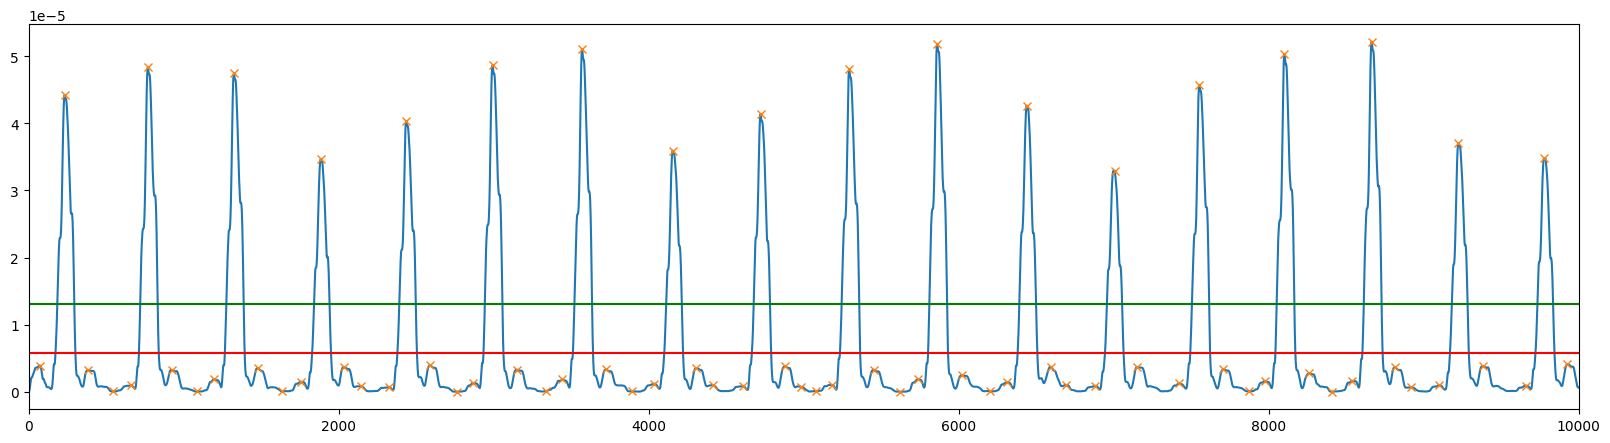

In [36]:
# Training Part to set Threshold I1 and Threshold I2
# Para las primeras muestras en 2 segundos
# Para efectos del ejercicio vamos a analizar toda la señal
f_samples = len(peaks)
th_I1 = np.max(fi_signal[peaks[:f_samples]])*0.25
th_I2 = 0.5*np.mean(fi_signal[peaks[:f_samples]])
print ("El valor del umbral de pico R de entrada es ", th_I1)
print ("El valor del umbral de ruido de entrada es ", th_I2)
plt.figure(figsize=(20,5))
plt.plot(fi_signal); plt.xlim([0,10000])
#plt.xlim(50,1000)
plt.plot(peaks, fi_signal[peaks], "x")
plt.hlines(th_I1, 0, len(fi_signal), colors='green')
plt.hlines(th_I2, 0, len(fi_signal), colors='red')
plt.show()

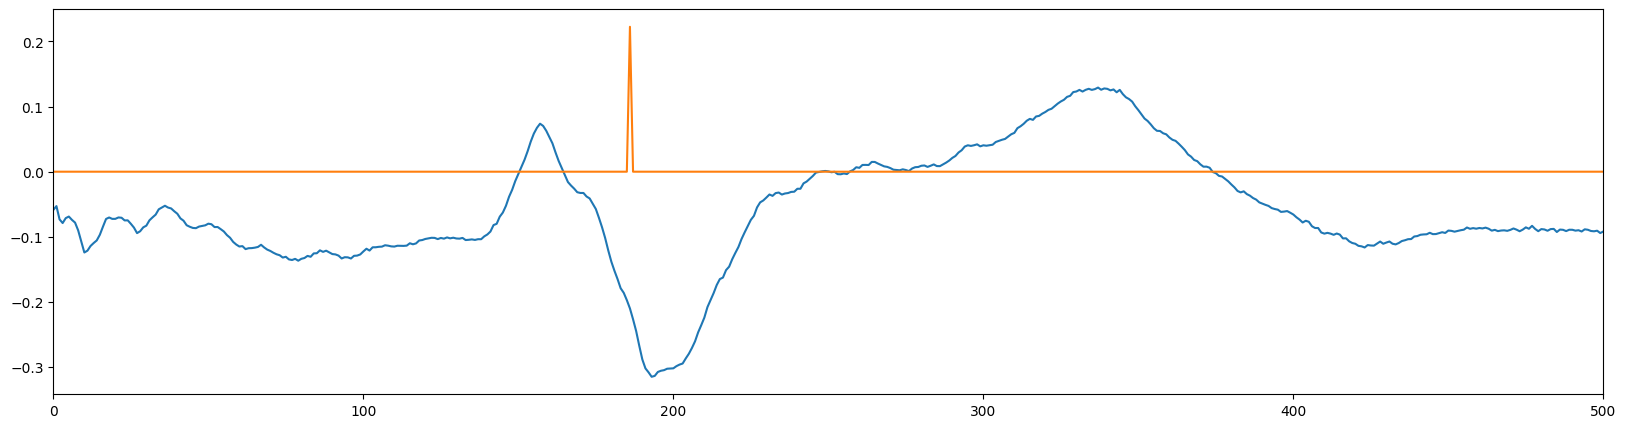

In [37]:
end_qrs = fi_signal > th_I1
roll_qrs_r = np.roll(end_qrs, 1)
roll_qrs_l = np.roll(end_qrs, -1)
end_qrs = np.logical_xor(end_qrs ,roll_qrs_r)
end_qrs = np.logical_and(end_qrs ,roll_qrs_l)
plt.figure(figsize=(20,5))
plt.xlim(0,500)
plt.plot(ecg_signal)
plt.plot(end_qrs*np.max(ecg_signal))
plt.show()

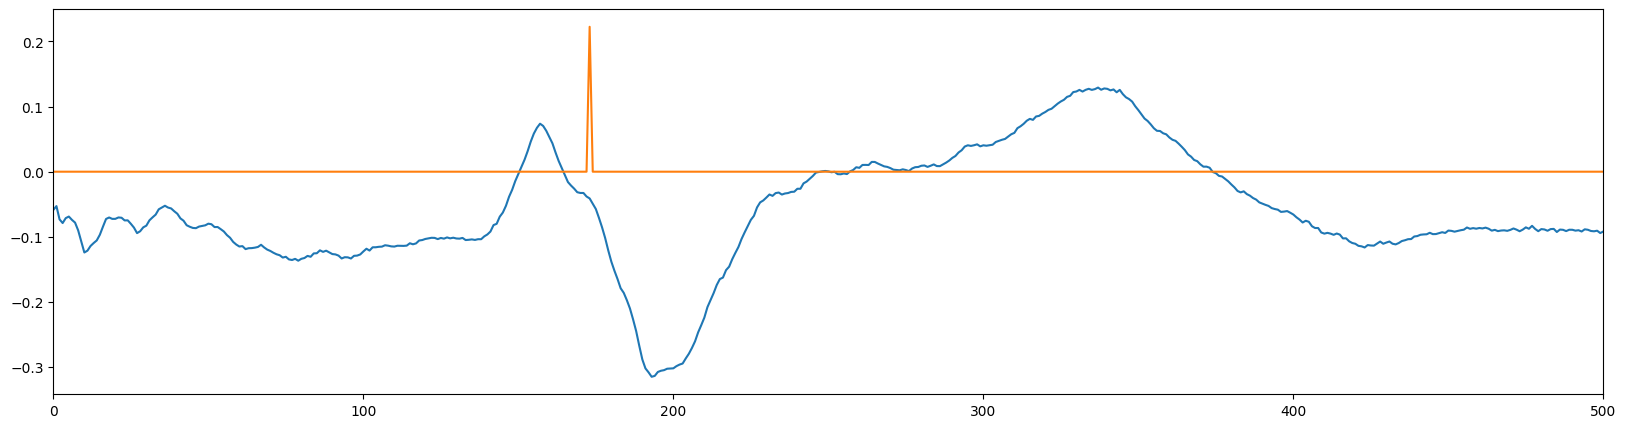

In [38]:
start_qrs = fi_signal < th_I2
roll_qrs_l = np.roll(start_qrs, -1)
roll_qrs_r = np.roll(start_qrs, 1)
start_qrs = np.logical_xor(start_qrs ,roll_qrs_l)
start_qrs = np.logical_and(start_qrs ,roll_qrs_r)
plt.figure(figsize=(20,5))
plt.plot(ecg_signal)
plt.xlim(0,500)
plt.plot(start_qrs*np.max(ecg_signal))
plt.show()

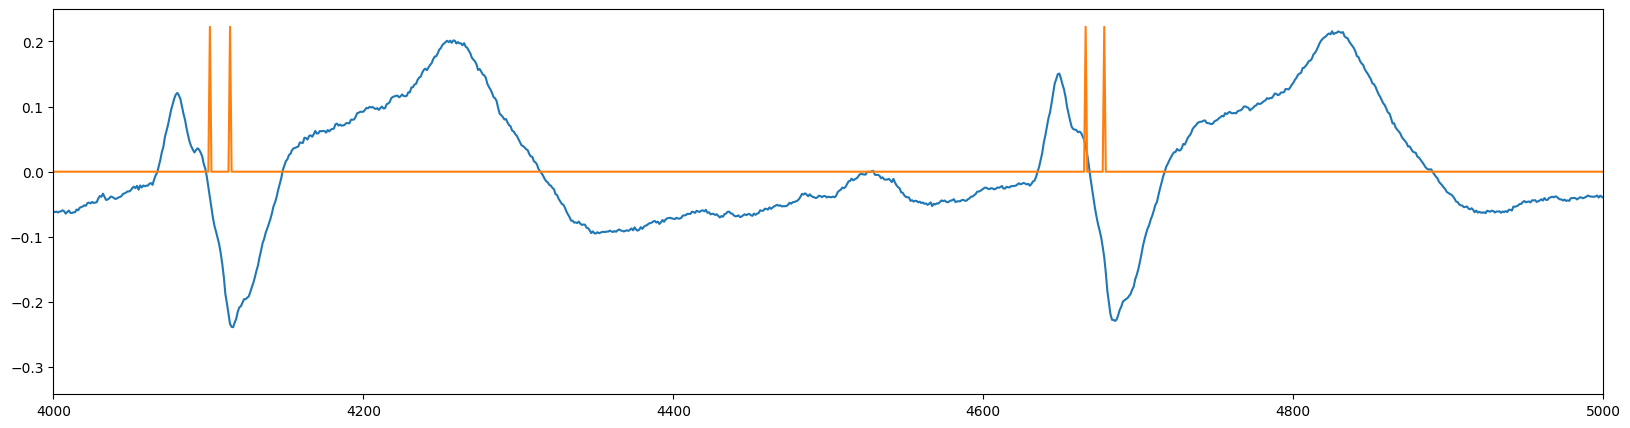

In [39]:
qrs = np.logical_or(start_qrs, end_qrs)
plt.figure(figsize=(20,5))
plt.xlim(4000,5000)
plt.plot(ecg_signal)
plt.plot(qrs*np.max(ecg_signal))
plt.show()


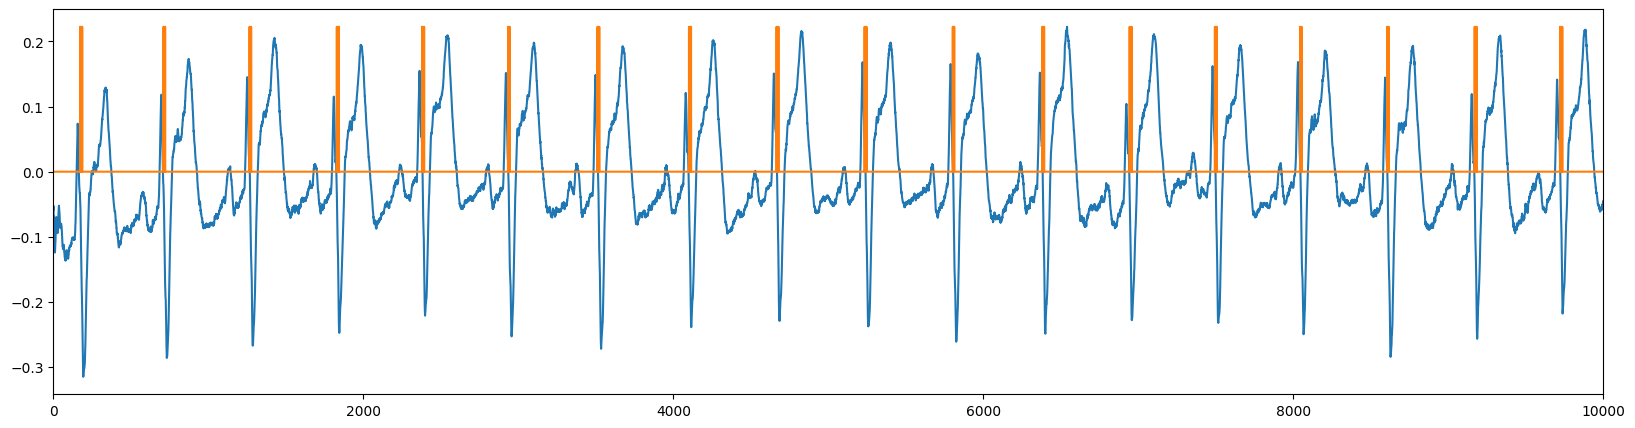

In [40]:
qrs = np.logical_or(start_qrs, end_qrs)
plt.figure(figsize=(20,5))
plt.plot(ecg_signal); plt.xlim([0, 10000])
plt.plot(qrs*np.max(ecg_signal))
plt.show()